In [7]:
%load_ext autoreload
%autoreload 2
import yaml
import pandas as pd
# from pandas.core.common import SettingWithCopyWarning
pd.options.mode.chained_assignment = None
# import warnings
# warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)
import numpy as np
import os
opj = os.path.join
opd = os.path.dirname
import glob
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import norm
from utils import *
from analyse import *

Z = norm.ppf

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [64]:
out='sub-012_ses-1_task-yesnoL_run-4' 
sub=out.split('_')[0]
tsk=out.split('_')[2].split('-')[-1][:-1]
attn=out.split('_')[2][-1].lower()
name='exp'
""
beh = AnalyseRun(out, tsk, attn,sub,name)
# beh.analyse2afc()
beh.analyseYesNo()

Settings file:  /data1/projects/dumoulinlab/Lab_members/Sumiya/programs/pRF_attention_task/Experiment/expsettings/expsettings_yesno.yml

Attention L
Proportions: [0.2, 0.8]
Response Keys: ['nan' 'b']

small D': 0.733, C: 1.352

large D': 3.044, C: 1.283

37 expected responses                          
23 actual subject responses                          
22 hits (within 1s)                          
15 misses                          
1 false alarms                          
Average RT: 0.686s



In [93]:
fname=opj(opd(os.environ['PATH_HOME']),'pRF_attention_task/Experiment/logs',sub,fn[0],fn[0].rsplit('_',1)[0]+'_events.tsv')
df=pd.read_table(fname,keep_default_na=True)
df.loc[df.event_type == 'stim','duration'] = np.diff(df.loc[df.event_type == 'stim','onset'],append=np.nan)

df = df.drop(df[(df.phase % 2 == 1) & (df.event_type == 'stim')].index.append(df[df.event_type == 'pulse'].index))
# df.drop(df[(df.duration > 1)].index,inplace=True)
# df.drop(df[pd.isna(df.duration) & (df.event_type != 'response')].index,inplace=True)
df['nr_frames'] = df['nr_frames'].fillna(0)
df['end'] = df.onset + df.duration
df['end_abs'] = df.onset_abs + df.duration
df['response'] = df.response.astype(str).apply(lambda x:x.lower())
stim_df = df[df.event_type == 'stim']
resp = 'b'
if resp not in df.response.unique():
    df.loc[df.response != 'nan','response'] = 'b'
df['response'] = df.response.astype(str).apply(lambda x:x.lower())
responses = df.loc[df.response == resp]

responses

,trial_nr,onset,event_type,phase,response,nr_frames,large_prop,small_prop,onset_abs,duration,end,end_abs
32,14,22.398620,response,3,b,0.0,0.50,0.35,168.681238,NaN,NaN,NaN
66,21,32.239942,response,1,b,0.0,0.50,0.65,178.522560,NaN,NaN,NaN
112,30,45.641316,response,1,b,0.0,0.50,0.65,191.923934,NaN,NaN,NaN
143,36,54.674643,response,1,b,0.0,0.50,0.65,200.957261,NaN,NaN,NaN
169,41,62.265452,response,1,b,0.0,0.50,0.35,208.548070,NaN,NaN,NaN
195,46,69.632120,response,1,b,0.0,0.50,0.35,215.914738,NaN,NaN,NaN
222,51,77.366114,response,2,b,0.0,0.50,0.50,223.648732,NaN,NaN,NaN
286,64,96.226824,response,0,b,0.0,0.75,0.50,242.509442,NaN,NaN,NaN
320,70,106.480709,response,3,b,0.0,0.50,0.35,252.763327,NaN,NaN,NaN
349,76,114.599267,response,1,b,0.0,0.50,0.50,260.881885,NaN,NaN,NaN


sub-011_ses-1_task-yesnoS_run-1
sub-011_ses-1_task-yesnoL_run-4
sub-011_ses-1_task-yesnoL_run-5
sub-011_ses-1_task-yesnoS_run-8
sub-011_ses-1_task-yesnoL_run-9
sub-011_ses-1_task-yesnoL_run-7
sub-011_ses-1_task-yesnoS_run-6
sub-011_ses-1_task-yesnoL_run-2
sub-011_ses-1_task-yesnoS_run-3


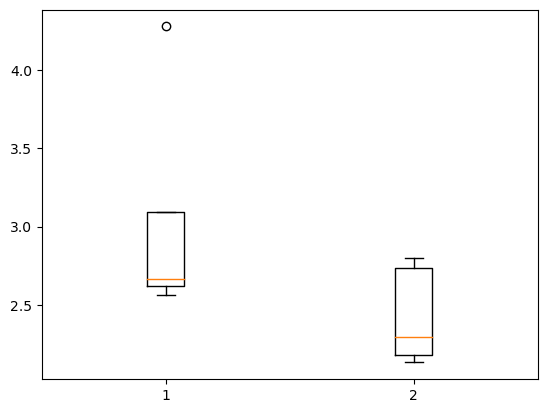

In [95]:
sub='sub-011'
n='exp'
r=None

fn=os.listdir(opj(opd(os.environ['PATH_HOME']),'pRF_attention_task/Experiment/logs',sub))
fn=[f for f in fn if 'ses-1_task-yesno' in f]
dL=[]
dS=[]

for f in fn:
    out=f[:-5]
    print(out)
    tsk=out.split('_')[2].split('-')[-1][:-1]
    attn=out.split('_')[2][-1].lower()
    name=n
    beh = AnalyseRun(out, tsk, attn,sub,name,verbose=False)
    beh.analyseYesNo(resp=r)
    if attn == 'l': 
        dL.append(beh.d)
    else:
        dS.append(beh.d)

plt.boxplot([dS,dL])
plt.show()
